In [1]:
import random
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from helpers import sample_batch, MLP

In [2]:
class DiffusionModel():
    def __init__(self, T, model: nn.Module, dim=2):
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        self.T = T
        self.model = model
        self.dim = dim

    def forward_process(self, x0, t):
        """
        param t: number of diffusion steps
        """
        assert t > 0, "should be greater than zero"
        t <= self.T, f"t should be lower or equal than {self.T}" 
        
        t = t - 1 # index start at zero
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt = mu + epsilon * std  # data ~ N(mu, std)

        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1 - self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1-self.alphas_bar[t-1]) / (1 - self.alphas_bar[t])
        mu_q = m1 * x0 + m2 * xt
        std_q = torch.sqrt( (1-self.alphas_bar[t-1]) / (1-self.alphas_bar[t]) * self.betas[t] )
        
        return mu_q, std_q, xt

    def reverse_process(self, xt, t):
        assert t > 0, "should be greater than zero"
        t <= self.T, f"t should be lower or equal than {self.T}"

        t = t - 1 # index start at zero
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        return  mu, std, mu + epsilon * std # data ~ N(mu, std)

    def sample(self, batch_size):
        noise = torch.randn(batch_size, self.dim)
        x = noise

        # adding the starting noise already makes the list composed of 41 elements (like in the paper)
        samples = [x]
        for t in range(self.T, 0, -1):
            # Edge effect of diffusione model (in the last step don't do anything)
            if not (t == 1):
                _, _, x = self.reverse_process(x, t)
            samples.append(x)

        return samples[:: -1] # reverse results in the list

    def get_loss(self, x0):
        """
        param x0: batch [batch_size, self.dim]
        """
        # sample t
        t = torch.randint(2, 40+1, (1,))
        mu_q , sigma_q, xt = self.forward_process(x0, t)
        mu_p, sigma_p,  xt_minus1 = self.reverse_process(xt.float(), t)
        # KL divergence for two gaussian distribution KL(q||p)
        KL = torch.log(sigma_p) -  torch.log(sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2)
        K_prime = - KL.mean() # we want to maximize K
        loss = -K_prime # should be minimized
        return loss

In [3]:
# pre-trained model
mlp_model = torch.load("./models/model_paper1")
model = DiffusionModel(40, mlp_model)

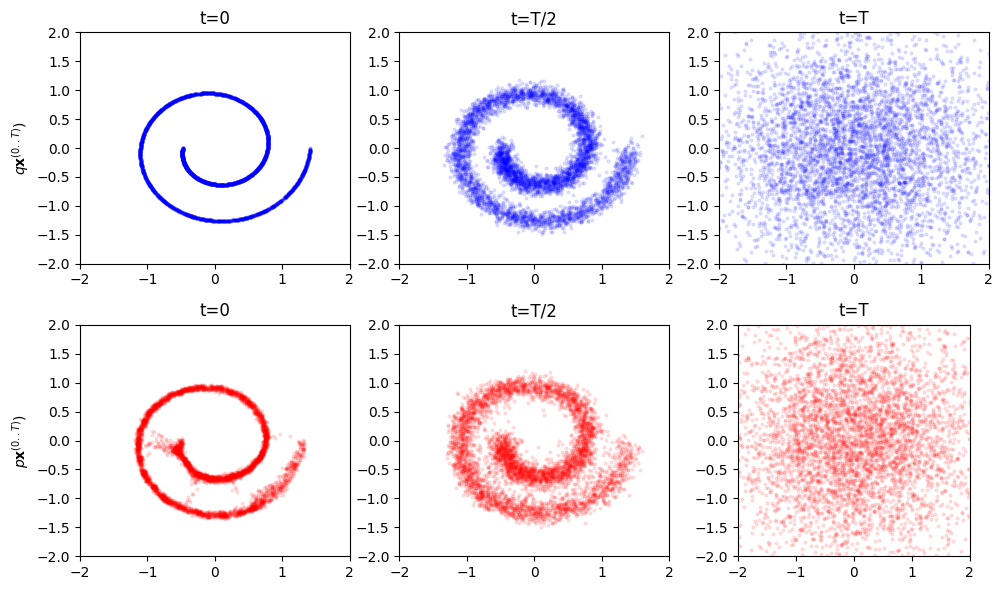

In [4]:
N = 5_000
x0= sample_batch(N)
samples = model.sample(N)

fontsize=22
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
# Common x and y limits
x_limits = (-2, 2)
y_limits = (-2, 2)

data = [
        [x0, model.forward_process(x0, 20)[-1], model.forward_process(x0, 40)[-1]],
        [samples[0], samples[20], samples[40]]
       ]
titles = ['t=0','t=T/2', 't=T']

for i in range(nrows):  # Iterate over rows
    for j in range(ncols):  # Iterate over columns
        colour = "b" if i == 0 else "r"
        if i == 0 and j == 0:
            ax[i,j].set_ylabel(r"$q\mathbf{x}^{(0..T)})$")
        if i == 1 and j == 0:
            ax[i,j].set_ylabel(r"$p\mathbf{x}^{(0..T)})$")
        ax[i,j].scatter(data[i][j][:, 0].data.numpy(), data[i][j][:, 1].data.numpy(), alpha=0.1, c= colour, s=4)
        ax[i,j].set_title(titles[j])
        ax[i,j].set_xlim(x_limits)
        ax[i,j].set_ylim(y_limits)
        plt.gca().set_aspect("equal")

plt.tight_layout()
#plt.savefig("diffusion_model_paper1_fig1.png", bbox_inches="tight")

In [5]:
N = 128
x0= sample_batch(N)

In [6]:
torch.manual_seed(42)
loss = model.get_loss(x0)
loss.detach().item()

0.6667477527651566

In [7]:
def train(diffusion_model, optimizer, batch_size, epochs):

    training_loss = []
    for epoch in tqdm(range(epochs)):
        xO = sample_batch(batch_size)
        loss = diffusion_model.get_loss(xO)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())

        if epoch % 100 == 0:
            plt.plot(training_loss)
            plt.savefig(f"train_loss_epoch_{epoch}.png")
            plt.show()
    
    return training_loss

In [8]:
mlp_model = MLP(hidden_dim=128)
diff_model = DiffusionModel(40, mlp_model)
optimizer = Adam(mlp_model.parameters(), lr=1e-4)

In [9]:
# just a try to see if the code works
train(diff_model, optimizer, 64_000, 500)

  0%|                                                                                                            | 1/1000 [00:00<04:13,  3.95it/s]

6.098368778680048


 10%|██████████▊                                                                                               | 102/1000 [00:20<02:57,  5.06it/s]

6.099602295447452


 20%|█████████████████████▎                                                                                    | 201/1000 [00:44<03:22,  3.95it/s]

1.0763182412498822


 30%|███████████████████████████████▉                                                                          | 301/1000 [01:09<02:37,  4.43it/s]

1.074244771317863


 40%|██████████████████████████████████████████▌                                                               | 401/1000 [01:35<02:24,  4.14it/s]

4.013313123690297


 50%|█████████████████████████████████████████████████████                                                     | 501/1000 [01:58<01:51,  4.46it/s]

5.960389130917129


 60%|███████████████████████████████████████████████████████████████▊                                          | 602/1000 [02:20<01:19,  5.02it/s]

1.041806250959214


 70%|██████████████████████████████████████████████████████████████████████████▎                               | 701/1000 [02:44<01:18,  3.81it/s]

2.6518862093827975


 80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 801/1000 [03:10<00:46,  4.32it/s]

0.9777244458466248


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▌          | 901/1000 [03:36<00:25,  3.83it/s]

5.857159271407023


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.12it/s]


[6.098368778680048,
 4.6838726198831,
 3.694715289597768,
 2.6909140384350385,
 3.6923822835729205,
 1.1023542640705706,
 1.1168678983011573,
 6.341109466942152,
 1.1145448288730795,
 1.0886024022046814,
 1.0986053757008012,
 5.488936903401105,
 1.30043652857063,
 6.020651451275631,
 6.093575725838837,
 1.484062879426346,
 1.1094445900795025,
 2.6883828747351584,
 4.966673563119216,
 3.0336333959964725,
 5.226537058591894,
 1.0930679154471374,
 6.103309961064778,
 5.4863215448925615,
 6.33895466657514,
 6.055958085975171,
 1.1528508532621473,
 1.0924531017531194,
 5.2243979080296326,
 6.149954313262688,
 4.678920904569221,
 1.1123572763513256,
 1.1032589838450593,
 4.359744367971251,
 1.1109416659744875,
 2.685884210767477,
 6.0188124468050805,
 3.0313997236373424,
 1.480406256607605,
 5.8336501629260304,
 1.1081768736931499,
 1.1510462457303787,
 1.1097968212421372,
 5.672024355686958,
 3.371499705420985,
 1.084895039843298,
 1.2963231479598245,
 2.012379464520471,
 1.0794800116547656